# Árvores de regressão - exercícios 01

*Atenção! Devido descontinuação da base de imóveis boston os alunos devem utilizar a base de dados que se encontra em anexo.*

A base que utilizaremos contem os dados dos imóveis da california.
Considerem como variável Target (a ser prevista) a coluna median_house_value.
O dataset é muito semelhante ao de boston, contendo localização, quartos, banheiros e outras variáveis interessantes para construção do modelo.

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse


### 1. Certifique-se de que esta base está no formato adequado para o scikitlearn.
ok, essa tarefa é tão fácil que você vai até desconfiar. Mas é preciso ter confiança sobre os dados que se usa ;)

In [32]:
pd.set_option('display.max_columns', None)

# 1) Ler dados
df = pd.read_csv('housing.csv')

# 2) Inspeções rápidas
display(df.head())
display(df.info())
print('Nulos por coluna:\n', df.isna().sum())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

Nulos por coluna:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [33]:
# 1) Criar variáveis derivadas
df['rooms_per_household']     = df['total_rooms'] / df['households']
df['bedrooms_per_room']       = df['total_bedrooms'] / df['total_rooms']
df['population_per_household']= df['population'] / df['households']

# 2) Dummies para a qualitativa
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=False)

# 3) Target e seleção de X numéricos
y = df['median_house_value']
X = df.drop(columns=['median_house_value'])

# Garantir numérico e checar nulos
print('Tipos numéricos? ', all(np.issubdtype(t, np.number) for t in X.dtypes))
print('Nulos em X:', X.isna().sum().sum(), '| Nulos em y:', y.isna().sum())
print('Shape X, y:', X.shape, y.shape)

display(X.head())

Tipos numéricos?  False
Nulos em X: 414 | Nulos em y: 0
Shape X, y: (20640, 16) (20640,)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,6.984127,0.146591,2.555556,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,6.238137,0.155797,2.109842,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,8.288136,0.129516,2.802260,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,5.817352,0.184458,2.547945,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,6.281853,0.172096,2.181467,False,False,False,True,False


### 2.  Visualize a matriz de correlação, e veja se aparentemente você encontra alguma variável com potencial preditivo interessante.

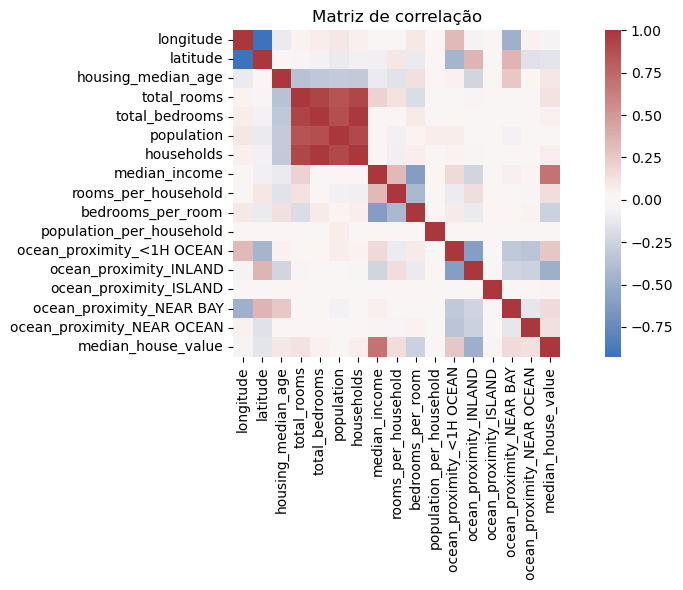

median_income                 0.688075
ocean_proximity_INLAND        0.484859
ocean_proximity_<1H OCEAN     0.256617
bedrooms_per_room             0.255880
ocean_proximity_NEAR BAY      0.160284
rooms_per_household           0.151948
latitude                      0.144160
ocean_proximity_NEAR OCEAN    0.141862
total_rooms                   0.134153
housing_median_age            0.105623
Name: median_house_value, dtype: float64


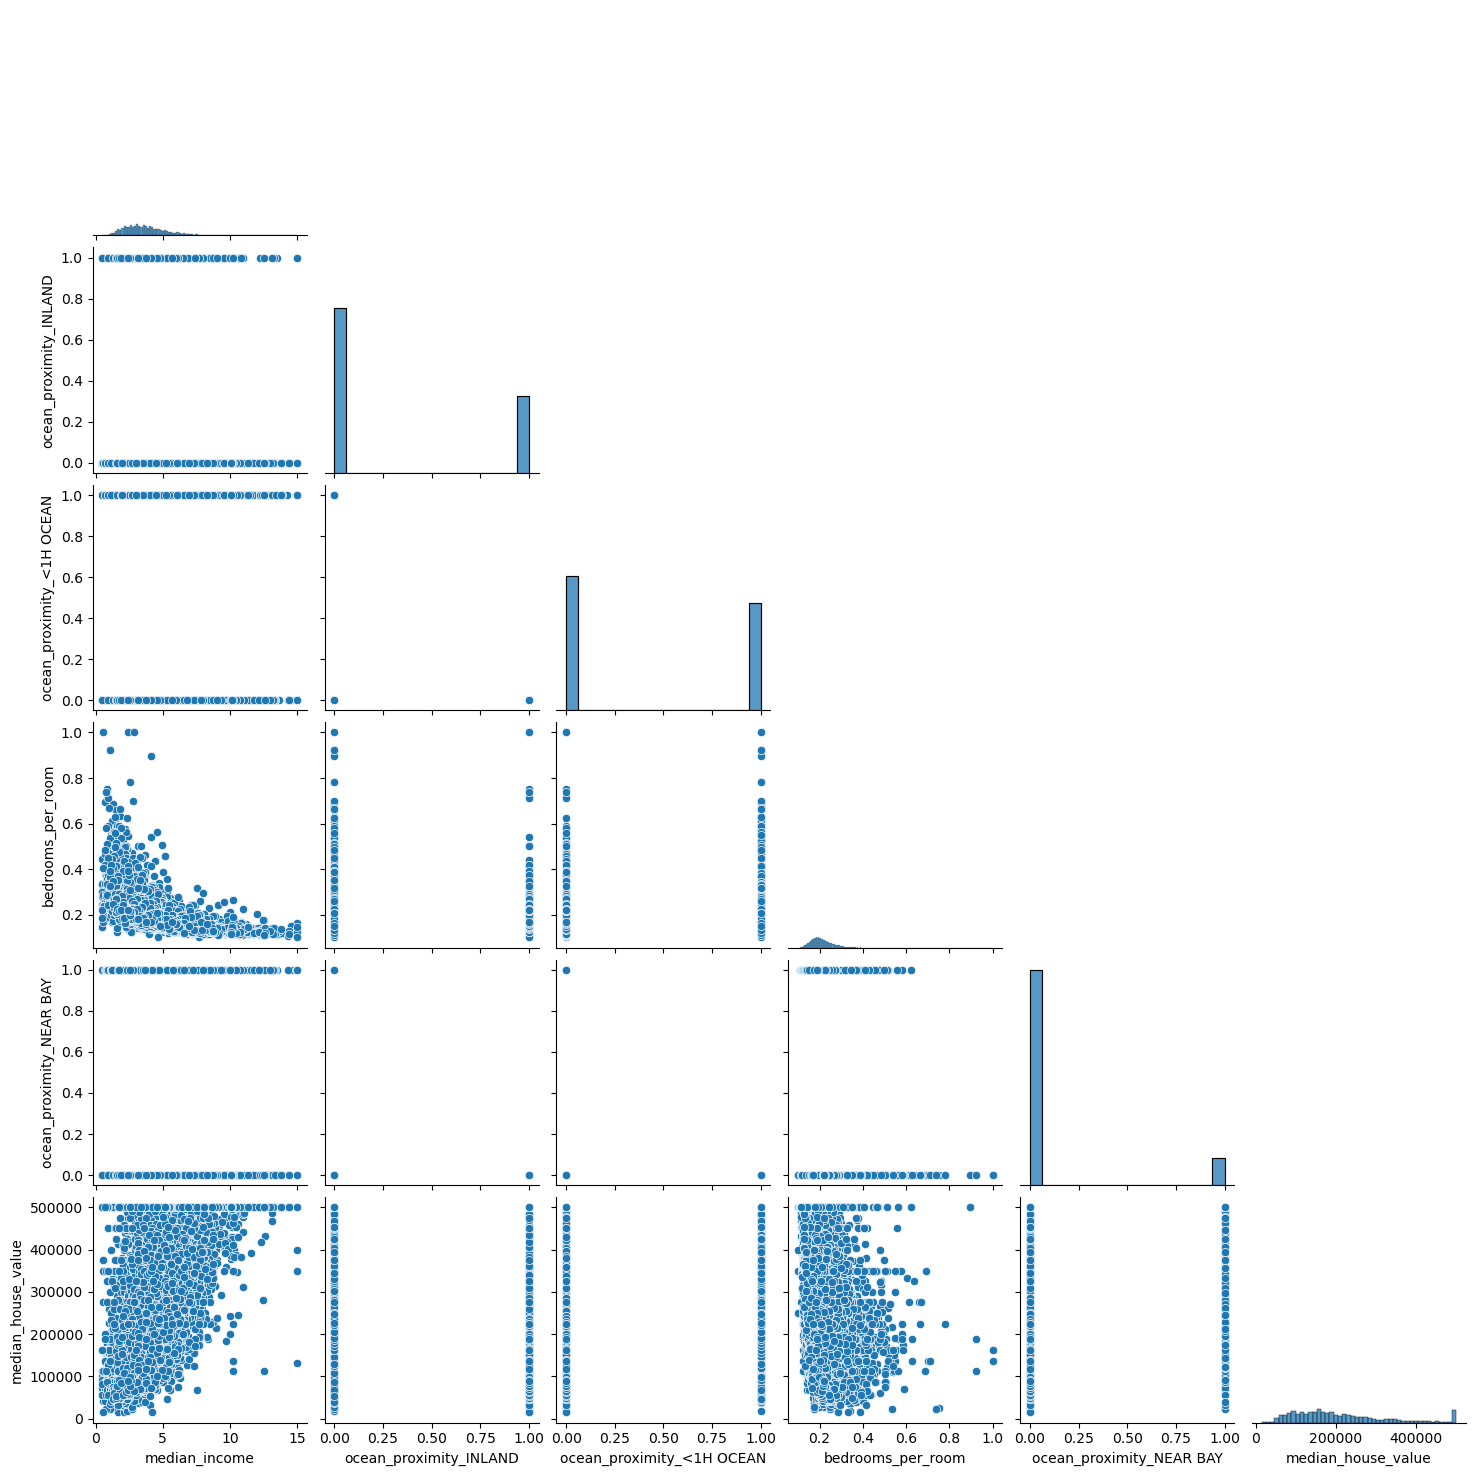

In [43]:
# Matriz de correlação (apenas numéricos)
df_corr = pd.concat([X, y.rename('median_house_value')], axis=1)

plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(numeric_only=True), cmap='vlag', center=0, square=True)
plt.title('Matriz de correlação')
plt.tight_layout(); plt.show()

# Top 5 correlações absolutas com a variável alvo
corr_target = df_corr.corr(numeric_only=True)['median_house_value'].drop('median_house_value')
print(corr_target.abs().sort_values(ascending=False).head(10))

# Pairplot com as 5 mais correlacionadas + alvo
top5 = corr_target.abs().sort_values(ascending=False).head(5).index.tolist()
sns.pairplot(df_corr[top5 + ['median_house_value']], corner=True, diag_kind='hist')
plt.show()


### 3. Separe os dados em validação e teste

In [35]:
# 3) Separar dados em treino/validação/teste (60/20/20)
from sklearn.model_selection import train_test_split

# 3.1) Primeiro: separar um teste de 20%
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 3.2) Depois: do restante, separar 25% para validação (vira 20% do total)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
)

# 3.3) Conferências rápidas
print('Formas:')
print('treino     ->', X_train.shape, y_train.shape)
print('validação  ->', X_val.shape,   y_val.shape)
print('teste      ->', X_test.shape,  y_test.shape)

# Mesmas colunas em todos os conjuntos
assert list(X_train.columns) == list(X_val.columns) == list(X_test.columns)

# Comparar médias do alvo (só para checar se os splits estão parecidos)
print('\nMédia do alvo por conjunto:')
print('treino    :', y_train.mean())
print('validação :', y_val.mean())
print('teste     :', y_test.mean())

Formas:
treino     -> (12384, 16) (12384,)
validação  -> (4128, 16) (4128,)
teste      -> (4128, 16) (4128,)

Média do alvo por conjunto:
treino    : 206807.7419250646
validação : 208355.54917635658
teste     : 205500.30959302327


### 4. Treine duas árvores, uma com profundidade máxima = 8, outra com profundidade máxima = 2.

In [36]:
# Árvore 1: mais profunda
tree8 = DecisionTreeRegressor(max_depth=8, random_state=42)
tree8.fit(X_train, y_train)

# Árvore 2: mais rasa (modelo mais simples)
tree2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

### 5. Calcule o MSE de cada uma das árvores do item anterior para a base de treinamento e para a base de testes.

In [44]:
# Árvore (max_depth=8)
ytr_8 = tree8.predict(X_train)
yva_8 = tree8.predict(X_val)
yte_8 = tree8.predict(X_test)

print('Árvore (max_depth=8)')
print('  MSE treino    :', mse(y_train, ytr_8))
print('  MSE validação :', mse(y_val,   yva_8))
print('  MSE teste     :', mse(y_test,  yte_8))

# Árvore (max_depth=2)
ytr_2 = tree2.predict(X_train)
yva_2 = tree2.predict(X_val)
yte_2 = tree2.predict(X_test)

print('\nÁrvore (max_depth=2)')
print('  MSE treino    :', mse(y_train, ytr_2))
print('  MSE validação :', mse(y_val,   yva_2))
print('  MSE teste     :', mse(y_test,  yte_2))


Árvore (max_depth=8)
  MSE treino    : 2789501005.91652
  MSE validação : 3946181150.9660134
  MSE teste     : 3875833564.7765803

Árvore (max_depth=2)
  MSE treino    : 6662264370.205243
  MSE validação : 6832500028.543161
  MSE teste     : 6896217359.579764


### 6. Com base nos resultados do item anterior, qual árvore te parece mais adequada?

Com base nos MSEs, a árvore com max_depth = 8 é a mais adequada, pois obteve erros menores em validação (~3.95×10⁹) e teste (~3.88×10⁹) do que a árvore com max_depth = 2 (~6.84–6.90×10⁹). Há indício de leve overfitting (treino muito melhor que validação/teste), então vale ajustar hiperparâmetros (ex.: profundidade intermediária, min_samples_leaf) para refinar o desempenho.

### 7. Faça uma visualização gráfica dessa árvore. Vamos discutir importância de variável mais adiante, mas veja a sua árvore, e pense um pouco: qual variável te parece mais "importante" na árvore?

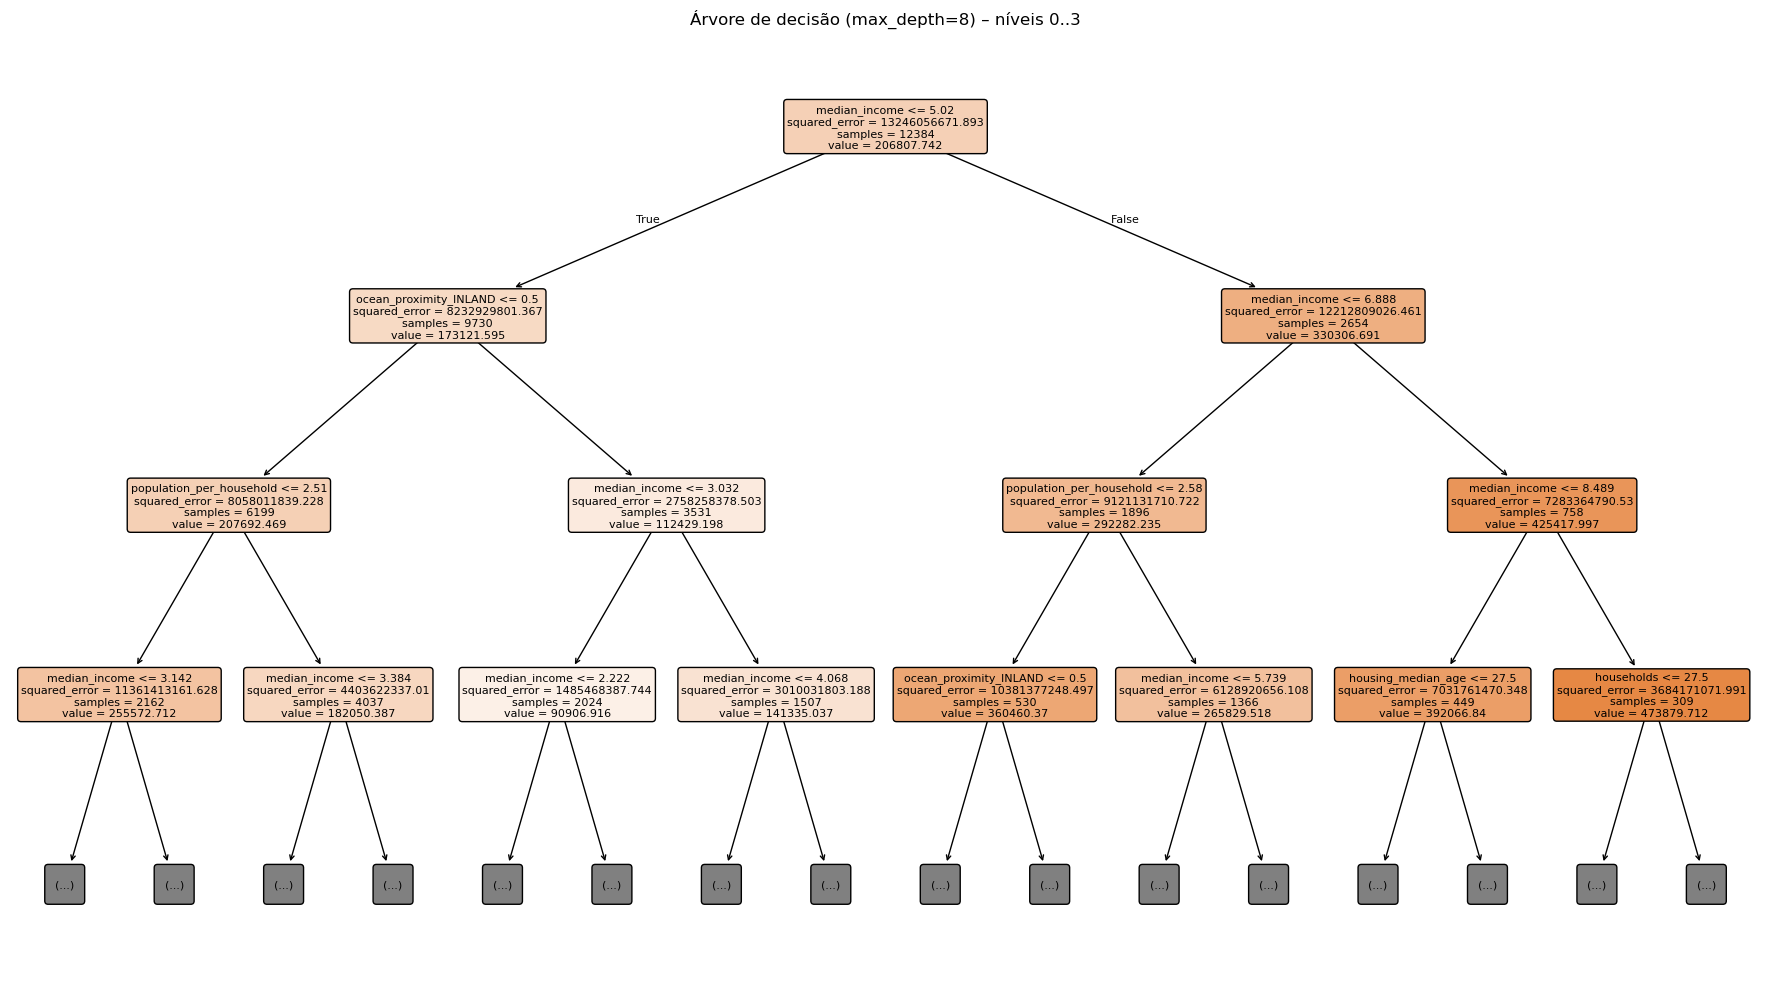

In [42]:
plt.figure(figsize=(18,10))
tree.plot_tree(
    tree8,
    feature_names=X_train.columns,
    filled=True, rounded=True,
    max_depth=3, fontsize=8
)
plt.title('Árvore de decisão (max_depth=8) – níveis 0..3')
plt.tight_layout(); plt.show()

A visualização da árvore (profundidade máx. = 8, níveis 0–3) mostra median_income no nó raiz, evidenciando que é o preditor mais influente de median_house_value. Em seguida, surgem divisões por ocean_proximity_INLAND e population_per_household, indicando relevância secundária de fatores geográficos e de densidade domiciliar. Ao longo dos ramos, median_income reaparece em vários níveis, reforçando seu peso. O padrão está alinhado à matriz de correlação observada: imóveis em áreas de maior renda tendem a apresentar valores medianos mais altos, modulados por localização (proximidade do oceano) e características demográficas.